In [114]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer
import torch 

In [115]:
df = pd.read_csv('../data/cyberbullying.csv')

df.info()

df
df['cyberbullying_type']
# #Sentiment mapping 
# sentiment_mapping = {'not_cyberbullying':0, 
#                      'ethnicity':1,
#                      'religion':2,
#                      'gender':3,
#                      'other_cyberbullying':4,
#                      'age':5}

<class 'pandas.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   tweet_text          47692 non-null  str  
 1   cyberbullying_type  47692 non-null  str  
dtypes: str(2)
memory usage: 745.3 KB


0        not_cyberbullying
1        not_cyberbullying
2        not_cyberbullying
3        not_cyberbullying
4        not_cyberbullying
               ...        
47687            ethnicity
47688            ethnicity
47689            ethnicity
47690            ethnicity
47691            ethnicity
Name: cyberbullying_type, Length: 47692, dtype: str

#### Our tweet_text is input text and the cyberbullying type is label 

### Checking if there is any missing value!

In [116]:
df.isnull()
# it returns False = no missing value 

,tweet_text,cyberbullying_type
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
47687,False,False
47688,False,False
47689,False,False
47690,False,False


In [117]:
df.drop_duplicates(inplace=True)

#### Check the class balance 

<Axes: title={'center': 'Distribution of Cyberbullying Categories'}, xlabel='cyberbullying_type'>

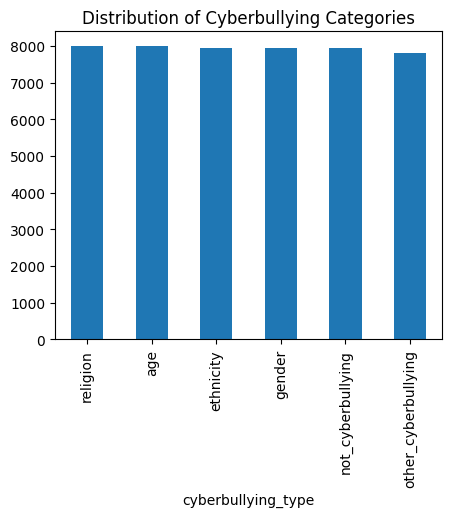

In [118]:
df['cyberbullying_type'].value_counts().plot(kind='bar',
                                              title='Distribution of Cyberbullying Categories',
                                              figsize=(5,4)
                                              )
# The result turns out to be good, the data is balanced 

### Word Cloud for uncleaned data

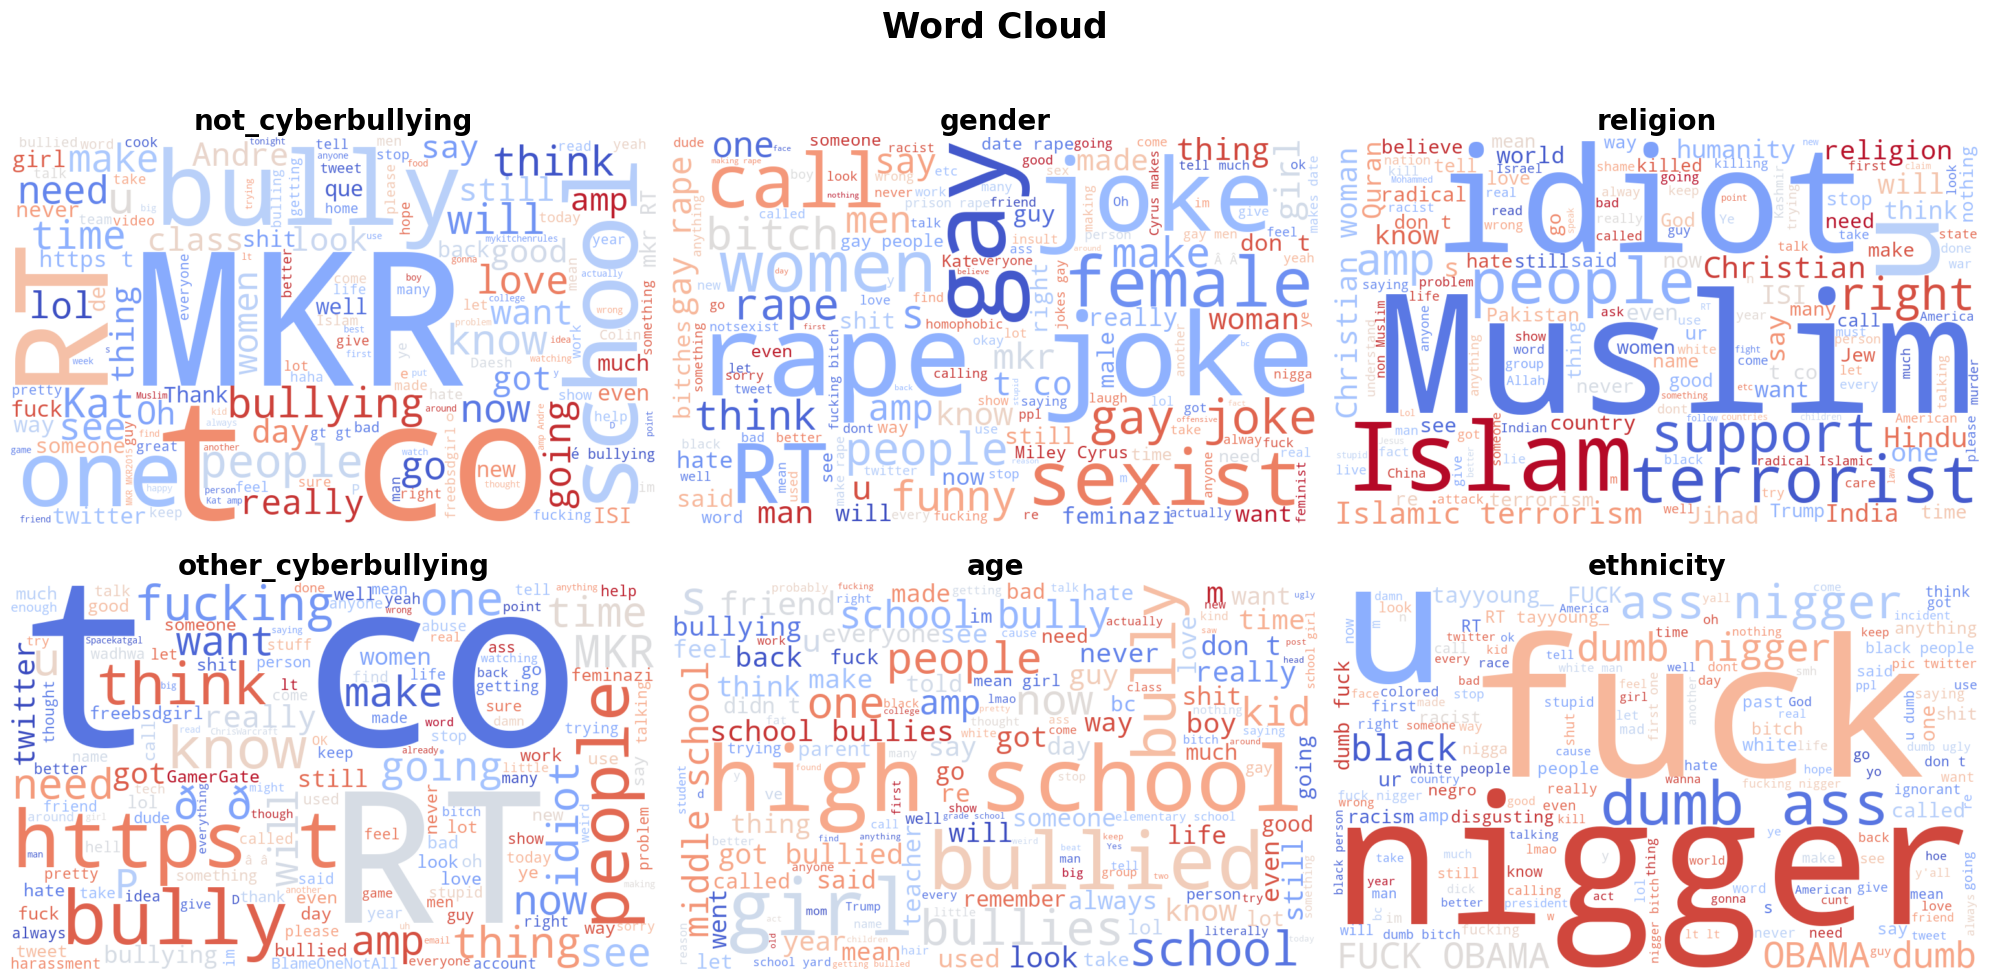

In [119]:

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

unique_labels = df['cyberbullying_type'].unique()
plt.figure(figsize=(20, 10))

for i, label in enumerate(unique_labels, 1):
    # Combine all tweets of this class
    text = " ".join(df[df['cyberbullying_type'] == label]['tweet_text'].astype(str))
    
    # Generate word cloud
    wc = WordCloud(
        width=1000, height=600,
        background_color='white',
        colormap='coolwarm',
        max_words=150,
        contour_color='black',
        contour_width=2
    ).generate(text)
    
    # Plot
    plt.subplot(2, (len(unique_labels)+1)//2, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{label}", fontsize=20, fontweight='bold')
    
plt.suptitle("Word Cloud", fontsize=25, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



### Normalize the text 

In [120]:
import re

def clean_text(text):
    text = text.lower()                         # lowercase
    text = re.sub(r"http\S+", "", text)         # remove URLs
    text = re.sub(r"@\w+", "", text)            # remove mentions
    text = re.sub(r"#\w+", "", text)            # remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)        # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text


### Preprocessing

In [121]:
preprocessed_df = df.copy()
#check the na and drop duplicate input
preprocessed_df = preprocessed_df.dropna(subset=['tweet_text', 'cyberbullying_type'])
preprocessed_df = preprocessed_df.drop_duplicates(subset = ['tweet_text']).reset_index(drop=True)
# we drop the other_cyberbullying
preprocessed_df = preprocessed_df[preprocessed_df['cyberbullying_type'] != 'other_cyberbullying'].reset_index(drop=True)

print(" After removing nulls, duplicates, and unwanted class:", preprocessed_df.shape)

# Apply the cleaned text to our newly created Preprocess dataframe 
preprocessed_df = preprocessed_df[preprocessed_df['tweet_text'].astype(str).str.strip() != ""]
preprocessed_df['cleaned_text'] = preprocessed_df['tweet_text'].apply(clean_text)
preprocessed_df = preprocessed_df[preprocessed_df['cleaned_text'].astype(str).str.strip() != ""].reset_index(drop=True)
preprocessed_df = preprocessed_df[preprocessed_df['cleaned_text'].str.len()>0] # Check missing value after cleaning 

# Save the preprocess dataframe 
# preprocessed_df.to_csv("cyberbullying_preprocessed_df.csv", index=False)


print(" Text cleaning process complete!")
print(f"Remaining samples: {len(preprocessed_df)}")
# print(" Preprocessed data saved to: cyberbullying_preprocessed_df.csv")
print("\n Preview of Cleaned Data:")
print(preprocessed_df[['tweet_text', 'cyberbullying_type', 'cleaned_text']].head(10))

 After removing nulls, duplicates, and unwanted class: (39774, 2)
 Text cleaning process complete!
Remaining samples: 39601

 Preview of Cleaned Data:
                                          tweet_text cyberbullying_type  \
0  In other words #katandandre, your food was cra...  not_cyberbullying   
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   
5  @Raja5aab @Quickieleaks Yes, the test of god i...  not_cyberbullying   
6  Itu sekolah ya bukan tempat bully! Ga jauh kay...  not_cyberbullying   
7  Karma. I hope it bites Kat on the butt. She is...  not_cyberbullying   
8       @stockputout everything but mostly my priest  not_cyberbullying   
9  Rebecca Black Drops Out of School Due to Bully...  not_cyberbullying   

                       

<Axes: title={'center': 'Distribution of Cyberbullying Categories'}, xlabel='cyberbullying_type'>

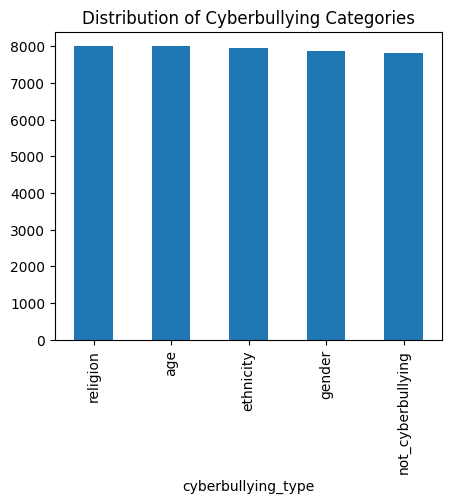

In [122]:
preprocessed_df['cyberbullying_type'].value_counts().plot(kind='bar',
                                              title='Distribution of Cyberbullying Categories',
                                              figsize=(5,4)
                                              )

In [123]:
X = preprocessed_df['cleaned_text'].values
y = preprocessed_df['cyberbullying_type'].values

preprocessed_df.shape
preprocessed_df['cyberbullying_type'].value_counts()

cyberbullying_type
religion             7995
age                  7992
ethnicity            7946
gender               7861
not_cyberbullying    7807
Name: count, dtype: int64

### Word Cloud afte the preprocessing 

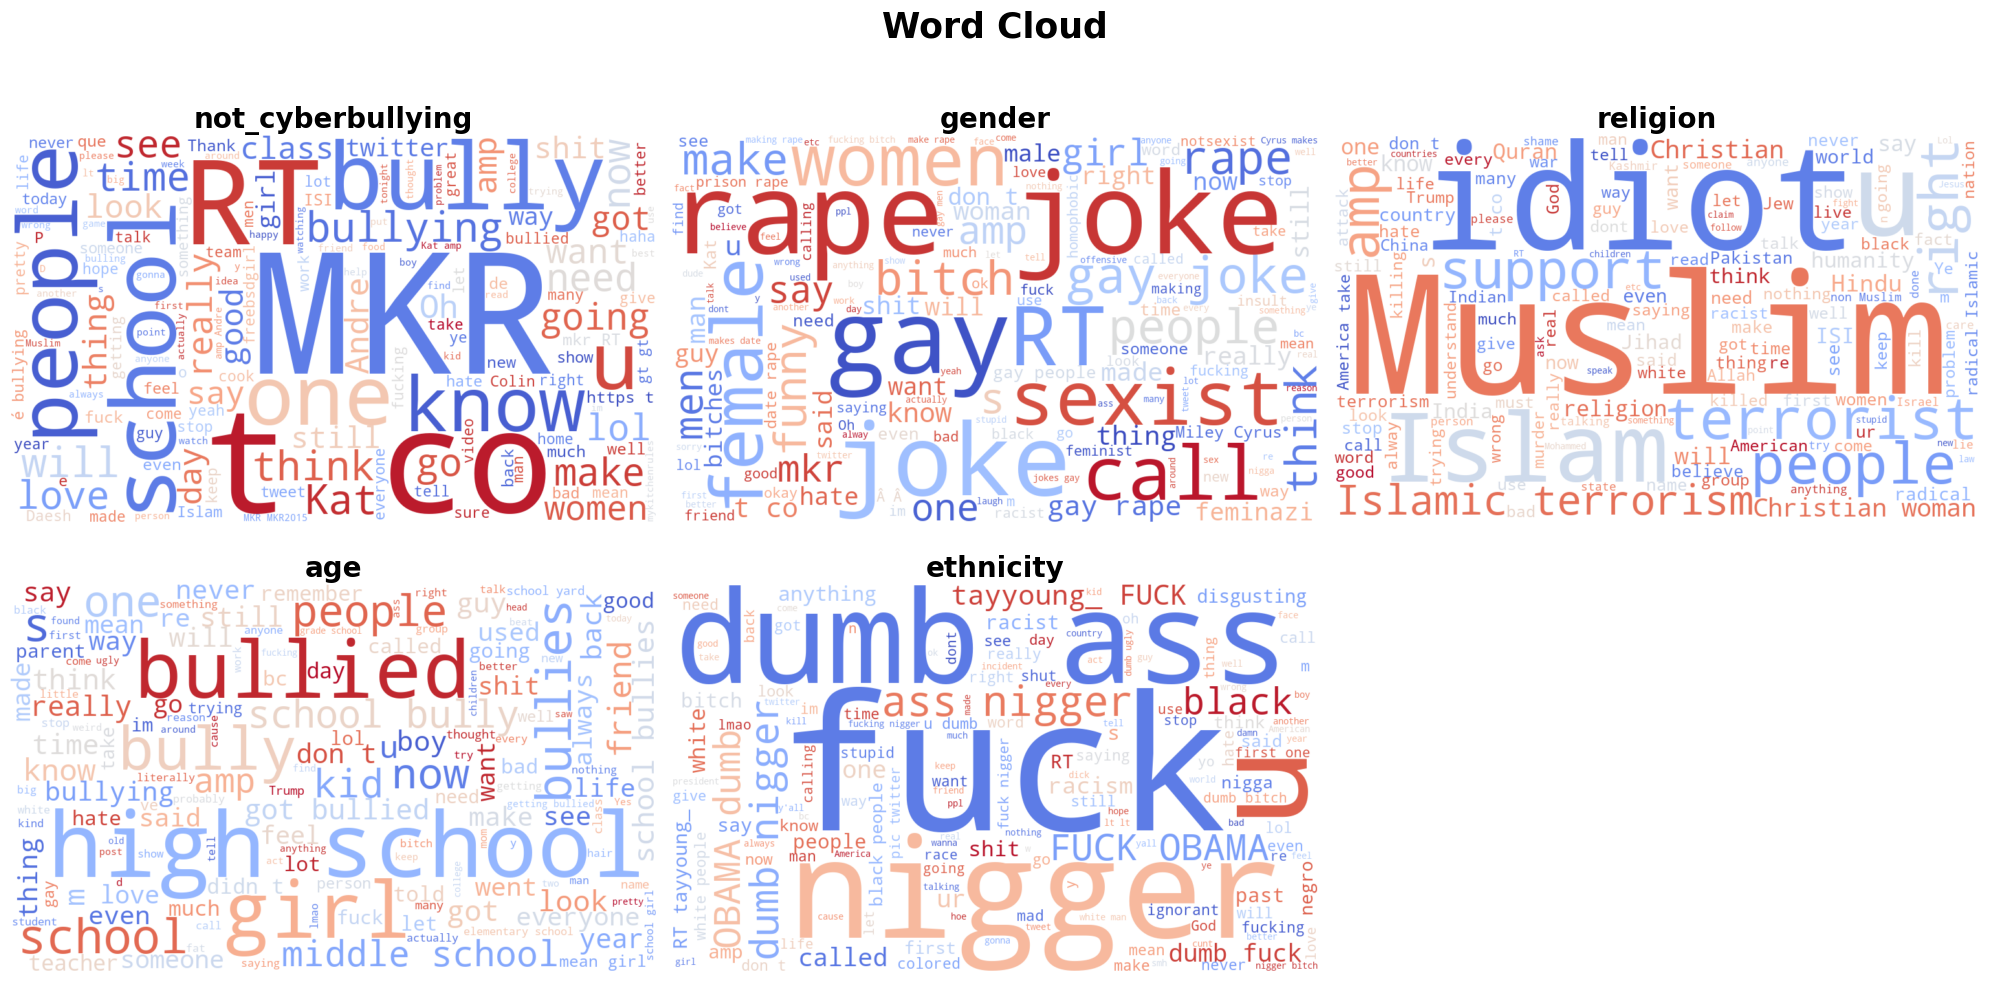

In [124]:

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

unique_labels = preprocessed_df['cyberbullying_type'].unique()
plt.figure(figsize=(20, 10))

for i, label in enumerate(unique_labels, 1):
    # Combine all tweets of this class
    text = " ".join(preprocessed_df[preprocessed_df['cyberbullying_type'] == label]['tweet_text'].astype(str))
    
    # Generate word cloud
    wc = WordCloud(
        width=1000, height=600,
        background_color='white',
        colormap='coolwarm',
        max_words=150,
        contour_color='black',
        contour_width=2
    ).generate(text)
    
    # Plot
    plt.subplot(2, (len(unique_labels)+1)//2, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{label}", fontsize=20, fontweight='bold')
    
plt.suptitle("Word Cloud", fontsize=25, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


      Dataset Size Comparison
Before Preprocessing : 47,656 rows
After Preprocessing  : 39,601 rows
Rows Removed         : 8,055 rows


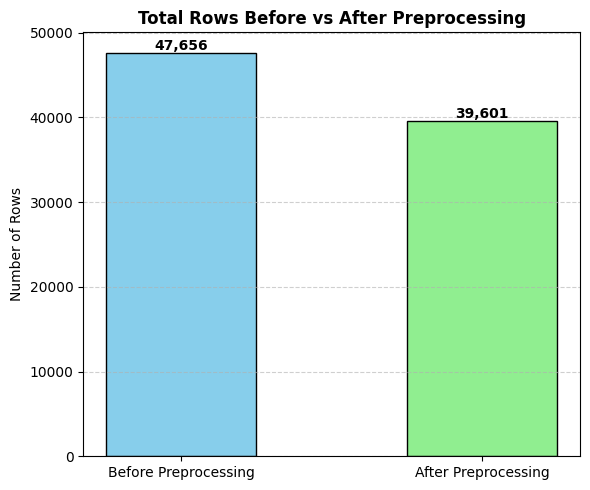

In [125]:
# Count total rows before and after
before_count = len(df)
after_count = len(preprocessed_df)

print("      Dataset Size Comparison")
print("==================================")
print(f"Before Preprocessing : {before_count:,} rows")
print(f"After Preprocessing  : {after_count:,} rows")
print(f"Rows Removed         : {before_count - after_count:,} rows")


plt.figure(figsize=(6, 5))
plt.bar(['Before Preprocessing', 'After Preprocessing'],
        [before_count, after_count],
        color=['skyblue', 'lightgreen'],
        width=0.5,
        edgecolor='black')

# Add value labels
for i, v in enumerate([before_count, after_count]):
    plt.text(i, v + 300, f"{v:,}", ha='center', fontweight='bold')


plt.title("Total Rows Before vs After Preprocessing", fontweight='bold')
plt.ylabel("Number of Rows")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Train Test Split

#### To turn sparse matrix to str array, 
##### we use:
##### -X_train_dense = X_train.toarray() #use a lot of memory 
   #####  X_train_str = X_train_dense.astype(str)

In [126]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.1765, random_state=42, stratify=y_temp)
print('\nShape:')
print(f'X_train shape: {len(X_train)} samples')
print(f'X_test shape: {len(X_test)} samples')
print(f'X_val shape: {len(X_val)} samples')
print(f'X_temp shape: {len(X_temp)} samples')
### 70/15/15 split 


Shape:
X_train shape: 27719 samples
X_test shape: 5941 samples
X_val shape: 5941 samples
X_temp shape: 33660 samples


### Feature Extraction -- TF-IDF

In [127]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            max_features=5000,
                            stop_words='english'
                            )
tfidf_X_train = vectorizer.fit_transform(X_train) # turn array into sparse matrix 
tfidf_X_val = vectorizer.transform(X_val)
tfidf_X_test = vectorizer.transform(X_test)
feature_y = preprocessed_df['cyberbullying_type']
vocab = vectorizer.vocabulary_

tfidf_X_train.shape
tfidf_X_val.shape
tfidf_X_test.shape

(5941, 5000)

In [128]:
classi_tfidf = LogisticRegression(max_iter=1000,
                                  C=1,                      # we can tune this 
                                  class_weight='balanced',  # it is helpful when sligh imbalance happen
                                  random_state=42)

classi_tfidf.fit(tfidf_X_train, y_train)
# We make a prediction on validation set 

pred_y_val = classi_tfidf.predict(tfidf_X_val)
accuracy_val = accuracy_score(y_val, pred_y_val)


print('\nValidation set Performance with TF-IDF:')
print(f'Accuracy: {accuracy_val:.4f}')
print('\nClassification Report:')
print(classification_report(y_val, pred_y_val))


pred_y_test = classi_tfidf.predict(tfidf_X_test)
accuracy_test = accuracy_score(y_test, pred_y_test)

print('\nTest set Performance with TF-IDF:')
print(f'Accuracy: {accuracy_test:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, pred_y_test))


Validation set Performance with TF-IDF:
Accuracy: 0.9150

Classification Report:
                   precision    recall  f1-score   support

              age       0.96      0.96      0.96      1199
        ethnicity       0.99      0.98      0.98      1192
           gender       0.92      0.84      0.88      1180
not_cyberbullying       0.77      0.85      0.81      1171
         religion       0.95      0.94      0.95      1199

         accuracy                           0.91      5941
        macro avg       0.92      0.91      0.92      5941
     weighted avg       0.92      0.91      0.92      5941


Test set Performance with TF-IDF:
Accuracy: 0.9172

Classification Report:
                   precision    recall  f1-score   support

              age       0.96      0.96      0.96      1199
        ethnicity       0.96      0.98      0.97      1192
           gender       0.93      0.85      0.89      1179
not_cyberbullying       0.78      0.87      0.82      1171
         rel

In [129]:
best_acc = 0
best_C = None
best_model = None

for C in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    clf = LogisticRegression(max_iter=1000, C=C, random_state=42)
    clf.fit(tfidf_X_train, y_train)
    pred_val = clf.predict(tfidf_X_val)
    acc = accuracy_score(y_val, pred_y_val)
    print(f"C = {C:4.1f} → Val accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_C = C
        best_model = clf

print(f"\nBest C = {best_C} (val acc = {best_acc:.4f})")

# Now use best_model on test set
pred_y_test = best_model.predict(tfidf_X_test)
print("\nTest accuracy with best model:", accuracy_score(y_test, pred_y_test))

C =  0.1 → Val accuracy: 0.9150
C =  0.5 → Val accuracy: 0.9150
C =  1.0 → Val accuracy: 0.9150
C =  2.0 → Val accuracy: 0.9150
C =  5.0 → Val accuracy: 0.9150
C = 10.0 → Val accuracy: 0.9150

Best C = 0.1 (val acc = 0.9150)

Test accuracy with best model: 0.9055714526174045


### Confusion Matrix

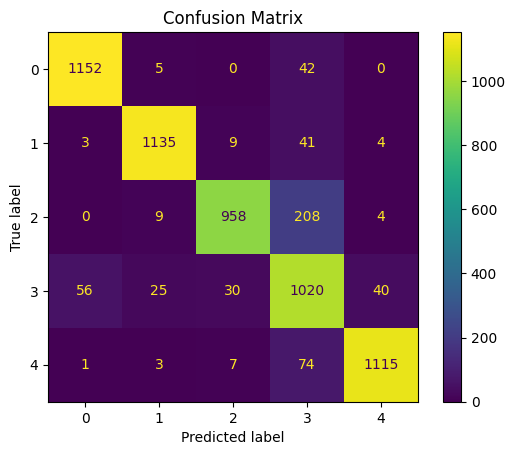

In [ ]:
class_names = ['not_cyberbullying', 
               'age',
               'ethnicity',
               'gender',
               'religion']

cm = confusion_matrix(y_test, pred_y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(9,7))
disp.plot(ax=ax, 
          cmap='blues',
          values_format='d',
          colorbar=True)
plt.title("Confusion Matrix - CyberBullying Type Prediction", 
          font_size=14,
            pad=20)
plt.xlabel('Predicted Cyberbullying Type', font_size=12)
plt.ylabel('Actual Cyberbullying Type', font_size=14) #rotate the long label 
plt.xticks(rotation=45, ha='right', fontsize=10)cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
plt.show()

### Word Embedding 

In [131]:

# from transformers import DistilBertTokenizer, AutoTokenizer
# import torch 

# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# train_encodings = tokenizer(X_train,
#                      truncation=True,
#                      padding=True,
#                      max_length=128)
# val_encodings = tokenizer(X_val,
#                      truncation=True,
#                      padding=True,
#                      max_length=128)



In [132]:

# class Cyberbullying(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
#         item["labels"] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# train_dataset = CyberDataset(train_encodings, X_train)
# val_dataset = CyberDataset(val_encodings, X_val)



In [133]:
# from transformers import DistilBertForSequenceClassification

# model = DistilBertForSequenceClassification.from_pretrained(
#     'distilbert-base-uncased',
#     num_labels=num_labels
# )


### Check if we have GPU or not 

In [134]:

# print(torch.cuda.is_available())


### Performance Metric 

In [135]:
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = logits.argmax(axis=1)

#     precision, recall, f1, _ = precision_recall_fscore_support(
#         labels, predictions, average='weighted'
#     )

#     acc = accuracy_score(labels, predictions)

#     return {
#         "accuracy": acc,
#         "f1": f1,
#         "precision": precision,
#         "recall": recall
#     }
